In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, Dot, Lambda
import tensorflow as tf
from tqdm.notebook import tqdm

In [3]:
from tqdm.notebook import tqdm
# Read data from text
with open('/content/train_snli.txt') as file:
    data = file.readlines()

# prepare csv file
with open('data.csv', 'w', newline= '') as csvfile:
    filenames = ['source_txt', 'keyword_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)

    writer.writeheader()
    for line in tqdm(data):
        parts = line.strip().split('\t')
        source_txt = parts[0]
        keyword_txt = parts[1]
        label = int(parts[2])

        writer.writerow({
            'source_txt' : source_txt,
            'keyword_txt' : keyword_txt,
            'label' : label
        })
print('CSV file created successfully...')

  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


In [ ]:
df = pd.read_csv('/content/data.csv')

In [ ]:
df.head()

,source_txt,keyword_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [ ]:
df.shape

(367373, 3)

In [ ]:
df.isnull().sum()

source_txt     0
keyword_txt    4
label          0
dtype: int64

In [ ]:
df.duplicated().sum()

454

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.shape)

source_txt     0
keyword_txt    0
label          0
dtype: int64
0
(366915, 3)


<Axes: xlabel='label'>

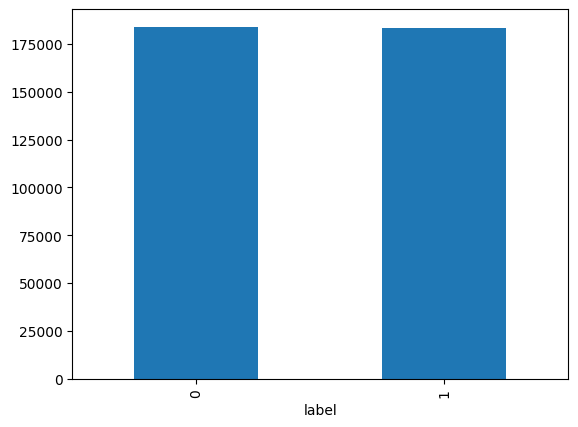

In [ ]:
df['label'].value_counts().plot(kind='bar')

In [ ]:
print(df['source_txt'][1])
print(df['keyword_txt'][1])

A person on a horse jumps over a broken down airplane.
A person is outdoors, on a horse.


In [ ]:
# Load data
df = pd.read_csv('/content/data.csv')

In [ ]:
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

def preprocess_text(text):
    if isinstance(text, str):
        text = text.translate(str.maketrans("", "", string.punctuation))
        text = text.lower()
    return text

df['source_txt'] = df['source_txt'].apply(preprocess_text)
df['keyword_txt'] = df['keyword_txt'].apply(preprocess_text)

# Split the data
X = df[['source_txt', 'keyword_txt']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize tokenizer and fit on texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['source_txt'].tolist() + X_train['keyword_txt'].tolist())

# Convert texts to sequences
X_train_seq_1 = tokenizer.texts_to_sequences(X_train['source_txt'].tolist())
X_train_seq_2 = tokenizer.texts_to_sequences(X_train['keyword_txt'].tolist())
X_test_seq_1 = tokenizer.texts_to_sequences(X_test['source_txt'].tolist())
X_test_seq_2 = tokenizer.texts_to_sequences(X_test['keyword_txt'].tolist())

# Pad sequences
max_length = max(max(len(seq) for seq in X_train_seq_1), max(len(seq) for seq in X_train_seq_2))
X_train_pad_1 = pad_sequences(X_train_seq_1, maxlen=max_length)
X_train_pad_2 = pad_sequences(X_train_seq_2, maxlen=max_length)
X_test_pad_1 = pad_sequences(X_test_seq_1, maxlen=max_length)
X_test_pad_2 = pad_sequences(X_test_seq_2, maxlen=max_length)


In [ ]:
# Define the model
embedding_dim = 100

input_1 = Input(shape=(max_length,))
input_2 = Input(shape=(max_length,))

embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length)

encoded_1 = embedding(input_1)
encoded_2 = embedding(input_2)

lstm = LSTM(64)

encoded_1 = lstm(encoded_1)
encoded_2 = lstm(encoded_2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
def cosine_similarity(vectors):
    x, y = vectors
    x = tf.nn.l2_normalize(x, axis=1)
    y = tf.nn.l2_normalize(y, axis=1)
    return tf.reduce_sum(x * y, axis=1, keepdims=True)

cosine_sim = Lambda(cosine_similarity)([encoded_1, encoded_2])

# Convert cosine similarity to percentage
percentage_output = Lambda(lambda x: x * 100)(cosine_sim)

model = Model(inputs=[input_1, input_2], outputs=percentage_output)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit([X_train_pad_1, X_train_pad_2], y_train, epochs=10, batch_size=32, validation_data=([X_test_pad_1, X_test_pad_2], y_test))

Epoch 1/10
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 1153s 125ms/step - accuracy: 0.5309 - loss: 701.3533 - val_accuracy: 0.5070 - val_loss: 296.4569
Epoch 2/10
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 1086s 117ms/step - accuracy: 0.5155 - loss: 257.0165 - val_accuracy: 0.5077 - val_loss: 246.2335
Epoch 3/10
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 1088s 115ms/step - accuracy: 0.5118 - loss: 221.9766 - val_accuracy: 0.5080 - val_loss: 231.3241
Epoch 4/10
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 1133s 119ms/step - accuracy: 0.5109 - loss: 197.6006 - val_accuracy: 0.5130 - val_loss: 209.4654
Epoch 5/10
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 1088s 117ms/step - accuracy: 0.5102 - loss: 185.4845 - val_accuracy: 0.5057 - val_loss: 209.0336
Epoch 6/10
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 1123s 120ms/step - accuracy: 0.5080 - loss: 185.1934 - val_accuracy: 0.5110 - val_loss: 220.2836
Epoch 7/10
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 1063s 116ms/step - accuracy: 0.5098 - loss: 189.8053 - val_accuracy: 0.5012 - val_loss: 200.3260
Epoch 8/10
9185/9185 ━━━━━━

In [ ]:
import tensorflowjs as tfjs

# Save model to TensorFlow.js format
tfjs.converters.save_keras_model(model, 'path_to_save_model')

print("Model saved in TensorFlow.js format")

failed to lookup keras version from the file,
    this is likely a weight only file
Model saved in TensorFlow.js format


In [ ]:
# Test with new input and get percentage similarity
new_source_txt = "This is a new source text."
new_keyword_txt = "long"

In [ ]:
new_source_txt = preprocess_text(new_source_txt)
new_keyword_txt = preprocess_text(new_keyword_txt)

new_source_seq = tokenizer.texts_to_sequences([new_source_txt])
new_keyword_seq = tokenizer.texts_to_sequences([new_keyword_txt])

new_source_pad = pad_sequences(new_source_seq, maxlen=max_length)
new_keyword_pad = pad_sequences(new_keyword_seq, maxlen=max_length)

In [ ]:
predicted_similarity = model.predict([new_source_pad, new_keyword_pad])
similarity_percentage = predicted_similarity[0][0]
print(f'Predicted Cosine Similarity: {similarity_percentage:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted Cosine Similarity: -2.77%


In [ ]:
import shutil
from google.colab import files

# Save model to TensorFlow.js format
save_dir = 'path_to_save_model'
tfjs.converters.save_keras_model(model, save_dir)

# Create a zip file of the saved model directory
shutil.make_archive(save_dir, 'zip', save_dir)

# Download the zip file
files.download(f'{save_dir}.zip')

print("Model saved and downloaded in TensorFlow.js format")

failed to lookup keras version from the file,
    this is likely a weight only file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved and downloaded in TensorFlow.js format
